# EE 617 Project: Sensor Fault Diagnosis Part 2

## ATC sensor fault diagnose

We build a state space model for an airplane circling an airport with its distance, azimuth and elevation angle measurements. Since computational resources are not constrained at an airport, we shall use Support Vector Machine to classify a sensor as faulty. We simulate both healthy and faulty sensor measurements for a given time. Then on this measurement signal we extract some features (like mean, std deviation etc) and then use it to train an SVM and also validate it.

### State Space model

Let $x_1, x_3, x_5$ denote position of aircraft in cartesian coordinates respectively and $x_2, x_4, x_6$ denote velocities in these respective directions. $x_7$ denotes the turn rate

Then 

$\frac{dX}{dt}=\begin{bmatrix} x_2  \\ -x_4x_7  \\ x_4  \\ x_2x_7 \\ x_6 \\ 0 \\ 0\end{bmatrix}+Q_d$

Here, $Q_d$ is $diag([0, \sigma_1^2, 0, \sigma_1^2, 0, \sigma_1^2, \sigma_2^2])$ (zero mean noise)

The sensor measurement equations are as follows

$y_1=\sqrt{x_1^2+x_3^2+x_5^2}$  (range)

$y_2=\tan^{-1}(x_3/x_1)$   (azimuth angle)

$y_3=\tan^{-1}\left( \frac{x_5}{\sqrt{x_1^2+x_3^2}} \right)$  (elevation angle)

Also measurement noise is added which is $R=diag([\sigma_r^2, \sigma_{\theta}^2, \sigma_{\phi}^2])$ (zero mean noise)

Initial Condition used for simulation is $x(0)=[1000, 0, 2650, 150, 200, 0, 3]$

(Give reference)

In [1]:
#Importing the librairies
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random
import scipy.linalg as sp
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score

In [2]:
class Radar(object):
    
    #State Space model of Radar
    def __init__(self):
        
        #States
        self.x1=1000
        self.x2=0
        self.x3=2650
        self.x4=150
        self.x5=200
        self.x6=0
        self.x7=3
        
        
    def y1(self):
        #Measure range/distance
        return sqrt(self.x1**2+self.x3**2+self.x5**2)
    
    def y2(self):
        #Measure azimuth
        return atan(self.x3/self.x1)
    
    def y3(self):
        #measure elevation
        return atan(self.x5/(sqrt(self.x1**2+self.x3**2)))
    
    def dxdt(self):
        
        #The model
        dx1dt=self.x2
        dx2dt=-self.x4*self.x7
        dx3dt=self.x4
        dx4dt=self.x2*self.x7
        dx5dt=self.x6
        dx6dt=0
        dx7dt=0
        a=np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt, dx7dt])
        return a
        
    def setState(self, X):
        
        #Set the current state to X
        self.x1=X[0]
        self.x2=X[1]
        self.x3=X[2]
        self.x4=X[3]
        self.x5=X[4]
        self.x6=X[5]
        self.x7=X[6]
        
        
    def getState(self):
        
        #Return the states
        return np.array([self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.x7])
    
    def update(self, delt, noise=False):
        #Use RK4 method to integrate
        
        #Initialise
        h=delt
        X0=self.getState()
        
        #K1 terms
        K1=h*self.dxdt()
        X1=X0+K1/2
        self.setState(X1)
        
        #K2 terms
        K2=h*self.dxdt()
        X2=X0+K2/2
        self.setState(X2)
        
        #K3 terms
        K3=h*self.dxdt()
        X3=X0+K3
        self.setState(X3)
        
        #K4 terms
        K4=h*self.dxdt()
        X=X0+K1/6+K2/3+K3/3+K4/6
        
        #If noise bool is true we want noise to be added so add it
        if noise==True:
            s1=0.2
            s2=7e-3
            Qd=np.diag([0, s1**2, 0, s1**2, 0, s1**2, s2**2])
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0, 0, 0], Qd)
        self.setState(X)
        
        
    def meas(self, noise=False):
        
        #Measurement
        x=self.getState()
        Y=np.array([self.y1(), self.y2(), self.y3()])
        
        if noise:
            #If noise bool is True then add nboise
            sr=50
            st=0.1
            sphi=0.1
            R=np.diag([sr**2, st**2, sphi**2])
            Y+=np.random.multivariate_normal([0, 0, 0], R)
        
        return Y

### Simulation

We simulate the aircraft for $N=500$ time instants with time step $0.1 second$ and plot its $x$ and $y$ coordinates. The plane circles around the airport since the turn rate doesn't change

In [3]:
a=Radar()
Data=[]
Ys=[]
T=0.1
N=500
for i in range(0, N):
    a.update(0.1, True)
    Data.append(a.getState())
    Ys.append(a.meas(True))

Data=np.array(Data)
Ys=np.array(Ys)

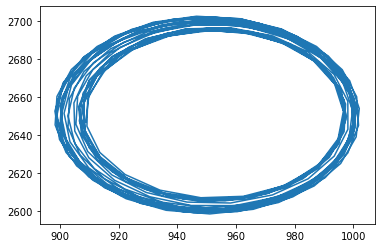

In [4]:
plt.plot(Data[:, 0], Data[:, 2])

In [5]:
class Sensor(object):
    
    #Sensor object its the same as from before in Part 1 of EE 617 Project
    def __init__(self):
        
        self.offset=0
        self.drift=0
        self.Fault=False
        self.model=None
        self.R=0
        self.t=0
        
    def setOffset(self, d):
        
        self.offset=d
        self.Fault=True
        
    def setDrift(self, m):
        
        self.drift=m
        self.t=0
        self.Fault=True
        
    def setModel(self, g, R):
        
        self.model=g
        self.R=R
        
    def meas(self, X):
        
        n, m=self.R.shape
        a=self.model(X)+self.offset+self.drift*self.t+np.random.multivariate_normal(np.zeros(n), self.R)
        self.t+=1
        return a
    
    def erraticScale(self, m):
        self.R=m*self.R
        self.Fault=True
        
    def clear(self):
        
        self.fault=False
        self.drift=0*self.drift
        self.t=0
        self.offset=0*self.offset
        
def smoother(E, N):
    
    #Smoothing function as as was used in EE 617 Part 1
    L=len(E)
    A=[]
    s=sum(E[:N])
    for i in range(N, L):
        A.append(s/N)
        s+=E[i]
        s-=E[i-N]
        
    return A

def Gx(X, Noisier=True):
    
    #The measurement function
    x1=X[0]
    x2=X[1]
    x3=X[2]
    x4=X[3]
    x5=X[4]
 
    y1=sqrt(x1**2+x3**2+x5**2)        #Range
    y2=atan(x3/x1)                    #Azimuth angle
    y3=atan(x5/(sqrt(x1**2+x3**2)))   #Elevation anlge
    
    Y=np.array([y1, y2, y3])   #Return the measurements as an array
        
        
    return Y

## Fault simulation-Offset

Now we simulate an offset fault in range sensor at some time instant. We also run in parallel a noiseless model and its measurement simulation. This basically represents actual measurements and simulated measurements (though here both are simulations, the former being noisy and latter being clean!)

In [6]:
Rsens=Sensor()       #Sensor Object

#Train the sensor
sr=50                 
st=0.1
sphi=0.1
R=np.diag([sr**2, st**2, sphi**2])  #Noise matrice
Rsens.setModel(Gx, R)      #Set the sensor to the particular noise level and measurement function of interest

In [7]:
a=Radar()     #Radar object that represents actual aircraft and its measuremnts
a2=Radar()    #Radar object thats supposed to be a simulation
Data=[]       #Here we shall store states data
Ys=[]         #Store measurements
E=[]          #Store actual - simulated measurements
T=0.1         #Time step
N=500         #total number of time steps
t=250         #time when fault occurs

for i in range(0, N):
    
    a.update(0.1, True)        #update actual aircraft with noise
    a2.update(0.1, False)      #update the dummy aircraft without noise
    Data.append(a.getState())  #get states data
    y=Rsens.meas(a.getState()) #get actual measurement
    y2=a2.meas(False)          #get simulated measurement without noise
    Ys.append(y)               #Store the measurement
    
    #Compute and store error
    e=y2-y
    E.append(e)
    
    if i==t:
        #If now is the time, induce fault
        Rsens.setOffset([100, 0, 0])

E=np.array(E)
Data=np.array(Data)
Ys=np.array(Ys)

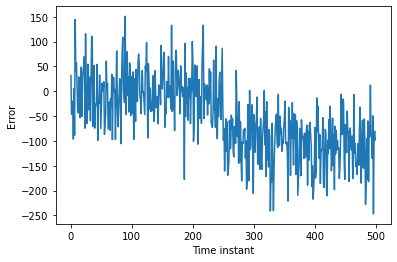

In [8]:
plt.plot(E[:, 0])
plt.xlabel('Time instant')
plt.ylabel('Error')
plt.show()

## Feature Extraction and SVM for diagnosis

On this error signal, we extract 10 features ($\mu_x$ is mean and $\sigma$ is std deviation on error signal)

$Y_{RMS}=\sqrt{\frac{1}{N}\sum_{i=1}^{N} x_i^2}$

$Y_{RMS}=\left( \frac{1}{N} \sum_{i=1}^{N} |x_i| \right)^2$

$Y_{KV}=1/N \sum_{i=1}^{N} \left( \frac{x_i-\mu_x}{\sigma}   \right)^4$

$Y_{SV}=1/N \sum_{i=1}^{N} \left( \frac{x_i-\mu_x}{\sigma}   \right)^3$

$Y_{PPV}= max(x)-min(x)$

$Y_{CF}=\frac{max(|x_i|)}{Y_{RMS}}$

$Y_{IF}=\frac{max(|x_i|)}{\frac{1}{N}\sum_{i=1}^{N}|x_i|}$

$Y_{MF}=\frac{max(|x_i|)}{Y_{SRA}}$

$Y_{SF}=\frac{max(|x|}{\sqrt {\frac{1}{N}\sum_{i=1}^{N}x_i^2}}$

$Y_{KF}=\frac{1/N \sum_{i=1}^{N} \left( \frac{x_i-\mu_x}{\sigma}   \right)^4}{\left( 1/N\sum_{i=1}^{N}x_i^2 \right)^2}$

For a given simulation for 500 time instants, we extract these features on the error signal. The idea is to perform this simulation many times, with fault induction in some cases and not in others. This data of these 10 features will be used to train an SVM that will classify a sensor error signal as faulty or okay. Using SVM, lot of process is automated i.e. we dont have to tweak and look for thresholds as was done in the induction motor case

In [9]:
def ExtractFeatures(E):
    
    
    #Based on the above formulae extract the features and return as numpy array
    Yrms=0
    absSum=0
    Ykv=0
    Ysv=0
    Ypv=0
    Ycf=0
    Yif=0
    Ymf=0
    Ysf=0
    Ykf=0
    N=len(E)
    M=sum(E)/N
    
    d=0
    for i in E:
        Yrms+=i**2
        d+=(i-M)**2
    
    Yrms=sqrt(Yrms/N)
    sigma=sqrt(d/N)
    
    for i in E:
        absSum+=(abs(i))
        Ykv+=((i-M)/sigma)**4
        Ysv+=((i-M)/sigma)**3
        
    Ysra=(absSum/N)**2
    Ykv=Ykv/N
    Ysv=Ysv/N
    Emax=max(E)
    Emin=min(E)
    Ypv=Emax-Emin
    Emaxabs=max(abs(Emax), abs(Emin))
    Ycf=Emaxabs/Yrms
    Yif=Emaxabs/(absSum/N)
    Ymf=Emaxabs/Ysra
    Ysf=Emax/Yrms
    Ykf=Ykv/(Yrms**4)
    
    return np.array([Yrms, Ysra, Ykv, Ysv, Ypv, Ycf, Yif, Ymf, Ysf, Ykf])
    
def normalise(F):
    
    #normalise the data, since we are going to be using SVM
    
    s=0
    for i in F:
        s+=abs(i)
    S=s
    return F/S

In [10]:
def simulate(Offset=0, N=500):
    
    #A simple function to perform the simulation with Offset Fault 
    #at some random time instant
    #If Offset=0 it automatically implies healthy simultions
    
    a=Radar()
    a2=Radar()
    Data=[]
    Ys=[]
    E=[]
    T=0.1
    E=[]
    t=int(random.uniform(N/10, N))   #The random time instant to generate fault
    
    for i in range(0, N):
        
        a.update(0.1, True)
        a2.update(0.1, False)
        Data.append(a.getState())
        y=Rsens.meas(a.getState())
        y2=a2.meas(False)
        Ys.append(y)
        E.append(y-y2)
        if i==t:
            
            Rsens.setOffset([Offset, 0, 0])
    

    Data=np.array(Data)
    E=np.array(E)
    
    Y1f=ExtractFeatures(E[:, 0])    #Extract features from error signal of range sensor
    Y2f=ExtractFeatures(E[:, 1])    #Extract features from error signal of azimuth sensor
    Y3f=ExtractFeatures(E[:, 2])    #Extract features from error signal of elevation sensor
    
    return Y1f, Y2f, Y3f

In [11]:
def genData(M=5, Offset=0):
    
    #Now lets do the rigorous long simulations, :(
    #We shall do M simulations with healthy sensor and M with faulty sensor
    
    #These shall store the extracted normalised features on the error signals
    Y1=[]   #Range sensor
    Y2=[]   #Azimuth sensor
    Y3=[]   #elevation sensor
    
    for i in range(0, M):
        
        #healthy simulations
        Y1f, Y2f, Y3f=simulate(0)
        Y1.append(Y1f)
        Y2.append(Y2f)
        Y3.append(Y3f)
        
    for i in range(0, M):
        
        #Perform the faulty simulations
        Y1f, Y2f, Y3f=simulate(Offset)
        Y1.append(Y1f)
        Y2.append(Y2f)
        Y3.append(Y3f)
    
    #Convert to numpy array it just makes life easier
    Y1=np.array(Y1)
    Y2=np.array(Y2)
    Y3=np.array(Y3)
    
    for i in range(0, 2*M):
        #normalise all the data
        Y1[i]=normalise(Y1[i])
        Y2[i]=normalise(Y2[i])
        Y3[i]=normalise(Y3[i])
        
    
    return Y1, Y2, Y3

## Example simulation

Now lets do the simulation of ATC 100 times with no fault in range sensor and then 100 times with sensor having an Offset fault of 60. Then we extract the features on each. Then we split the data in 60:40 ratio of train, test in 1000 different combinations. For each combination we train an SVM and calculate the accuracy, we print the average accuracy of these 1000 test-train combinations. This was how data was generated for the report

In [18]:
Y1, Y2, Y3=genData(100, 60)   #100 healthy and 100 faulty simulations with Offset 60

In [19]:
X=Y1
y=np.ones(200)     #Target Variable
for i in range(0, 100):
    y[i]=0         #First 100 sims are healthy and rest are faulty

In [20]:
Merit=[]    #Store accuracies
for i in range(0, 1000):
    X_train, X_test, y_train, y_test=tts(X, y, test_size=0.4, random_state=i) #Test train splitting
    
    #Train SVM
    model=svm.SVC(kernel='rbf')     
    model.fit(X_train, y_train)
    
    #Compute accuracy for this particular combination
    y_pred=model.predict(X_test)
    Merit.append(accuracy_score(y_test, y_pred))
    
#Print average accuracy
print(sum(Merit)/len(Merit))

0.9329374999999991


## Drift Fault in Range sensor

This is very similar to the offset fault, except that its drift, else everything is almost entirely same!!
Lets see an example simulation of the error signal

In [21]:
Rsens=Sensor()
sr=50
st=0.1
sphi=0.1
R=np.diag([sr**2, st**2, sphi**2])
Rsens.setModel(Gx, R)

In [22]:
a=Radar()
a2=Radar()
Data=[]
Ys=[]
E=[]
T=0.1
N=500
t=250
for i in range(0, N):
    a.update(0.1, True)
    a2.update(0.1, False)
    Data.append(a.getState())
    y=Rsens.meas(a.getState())
    y2=a2.meas(False)
    Ys.append(y)
    e=y2-y
    E.append(e)
    if i==t:
        Rsens.setDrift(np.array([1, 0, 0]))
    

E=np.array(E)
Data=np.array(Data)
Ys=np.array(Ys)

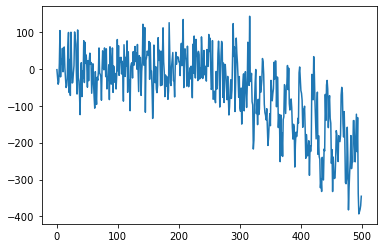

In [23]:
plt.plot(E[:, 0])

Similar functions defined below

In [29]:
def simulateDrift(drift=0, N=500):
    
    #automate the above process
    a=Radar()
    a2=Radar()
    Data=[]
    Ys=[]
    E=[]
    T=0.1
    E=[]
    t=int(random.uniform(N/10, N))   #At random time induce fault
    
    for i in range(0, N):
        a.update(0.1, True)
        a2.update(0.1, False)
        Data.append(a.getState())
        y=Rsens.meas(a.getState())
        y2=a2.meas(False)
        Ys.append(y)
        E.append(y-y2)
        if i==t:
            Rsens.setDrift(np.array([drift, 0, 0]))
    

    Data=np.array(Data)
    E=np.array(E)
    
    #Extract features and return
    Y1f=ExtractFeatures(E[:, 0])
    Y2f=ExtractFeatures(E[:, 1])
    Y3f=ExtractFeatures(E[:, 2])
    
    return Y1f, Y2f, Y3f

In [32]:
def genDataDrift(M=5, Drift=0):
    
    
    #M healthy, M faulty simulations same as offset except of course its drifting !!
    Y1=[]
    Y2=[]
    Y3=[]
    
    for i in range(0, M):
        
        Y1f, Y2f, Y3f=simulateDrift(0)
        Y1.append(Y1f)
        Y2.append(Y2f)
        Y3.append(Y3f)
        
    for i in range(0, M):
        
        Y1f, Y2f, Y3f=simulateDrift(Drift)
        Y1.append(Y1f)
        Y2.append(Y2f)
        Y3.append(Y3f)
        
    Y1=np.array(Y1)
    Y2=np.array(Y2)
    Y3=np.array(Y3)
    
    for i in range(0, 2*M):
        Y1[i]=normalise(Y1[i])
        Y2[i]=normalise(Y2[i])
        Y3[i]=normalise(Y3[i])
        
    
    return Y1, Y2, Y3

### Example simulation

Performing 100 healthy and 100 faulty simulations (drift -> 0.2). For 1000 combinations of train test splitting in ration of 60:40, train SVM and calculate accuracy and report finally the average accuracy.

In [33]:
Y1, Y2, Y3=genDataDrift(100, 0.2)   #100 healthy and 100 faulty simulations with drift 0.2

In [34]:
X=Y1
#Generate the target variable as before
y=np.ones(200)
for i in range(0, 100):
    y[i]=0

In [35]:
Merit=[]
for i in range(0, 1000):
    X_train, X_test, y_train, y_test=tts(X, y, test_size=0.4, random_state=i)   #Split 60-40
    
    #Train SVM
    model=svm.SVC(kernel='rbf')
    model.fit(X_train, y_train)
    
    #Calcuate accuracy
    y_pred=model.predict(X_test)
    Merit.append(accuracy_score(y_test, y_pred))
    
#Print average accuracy
print(sum(Merit)/len(Merit))

0.8726000000000008


This was the procedure used in generating data for report